# What are the theoretical maximum performance metrics?

AUTHOR: E Karvelis
DATE: 9/9/2023

Given that the TIS $\mathrm{k}_{cat}$ calculations are noisy, what values are even feasible for the various performance metrics that we consider? 

Here, we are mainly concerned with metrics for regression: Pearson correlation, Spearman rank correlation, and RMSE

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

np.random.seed(333)

In [4]:
# read data
df = pd.read_csv('/data/karvelis03/dl_kcat/input/variants_summary.csv')
df = df.loc[df['TIS log(k)'].to_numpy(str) != 'nan (nan)']
# display (df)

k_avgs = np.array([x.split('(')[0] for x in df['TIS log(k)']], dtype=float) 
k_errs = np.array([x.split('(')[-1].split(')')[0] for x in df['TIS log(k)']], dtype=float)

print (k_avgs)
print (k_errs)

[-13.57 -13.76 -14.39 -14.63 -14.74 -14.79 -14.83 -14.91 -14.97 -15.3
 -15.44 -15.56 -15.58 -15.7  -15.87 -15.89 -15.9  -16.   -16.05 -16.07
 -16.11 -16.22 -16.24 -16.31 -16.38 -16.47 -16.57 -16.62 -16.66 -16.67
 -16.79 -16.85 -16.87 -16.89 -16.94 -17.07 -17.16 -17.21 -17.21 -17.39
 -17.45 -17.47 -17.71 -17.71 -17.82 -17.91 -18.11 -18.24 -18.27 -18.57
 -18.69 -18.71 -18.99 -19.07 -19.53]
[0.52 0.38 0.21 0.3  0.29 0.22 0.37 0.59 0.67 0.13 0.41 0.25 0.44 0.46
 0.38 0.32 0.2  0.66 0.35 0.44 0.3  0.41 0.29 0.38 0.51 0.26 0.46 0.19
 0.21 0.32 0.36 0.36 0.28 0.26 0.21 0.35 0.41 0.46 0.32 0.38 0.48 0.25
 0.38 0.47 0.39 0.31 0.27 0.42 0.36 0.46 0.75 0.28 0.36 0.28 0.25]


In [11]:

class Experiment:
    # Bootstraps sets of kcat by sampling new values from 
    # normal distributions with mean = average and 
    # standard deviation = SEM

    def __init__(self, avgs, errs, n=10000, seed=333):
        # avgs -- the average values of the originally computed kcat's
        # errs -- the SEM associated with each computed kcat 
        # n    -- the number of experiments to run. 1 experiment 
        #         equals one resampling of noisy kcat values
        # seed -- random seed
        
        np.random.seed(seed)

        self.avgs = avgs
        self.errs = errs
        self.sampler = np.random.normal(loc=self.avgs, scale=self.errs)
        self.n = n
        self.samples = [[None]] # will later hold the resampled kcat values
        self.res = {} # dictionary to store results from the experiments
    
    def lognormal_sample(self):
        # This continues resampling kcat values from their respective
        # normal distributions until a set of ONLY positive values
        # is sampled. This is required because kcat CANNOT be 
        # negative.
        return np.random.normal(loc=self.avgs, scale=self.errs)

    def populate_samples(self):
        # Resamples one set of kcat values for each experiment, 
        # and each experiment corresponds to one row of values
        # written to self.samples
        samples = []
        for i in range(self.n):
            samples.append(self.lognormal_sample())
        self.samples = np.array(samples)

    @staticmethod
    def rmse(a1, a2):
        # calculates the RMSE between arrays a1 and a2
        # print (a1.shape)
        # print (a2.shape)
        # print ((a1-a2).shape)
        # print (((a1-a2)**2).shape)
        # print (np.mean((a1 - a2)**2))
        # print (np.mean((a1 - a2)**2)**0.5)
        return np.mean((a1 - a2)**2)**0.5

    def run(self):
        if self.samples[0][0] == None:
            self.populate_samples()
        
        print (f'self.samples.shape: {self.samples.shape}')

        self.res['spearman'] = np.array([spearmanr(self.samples[i], self.avgs)[0] for i in range(self.samples.shape[0])])
        self.res['pearson'] = np.array([pearsonr(self.samples[i], self.avgs)[0] for i in range(self.samples.shape[0])])
        self.res['RMSE'] = np.array([self.rmse(self.samples[i], self.avgs) for i in range(self.samples.shape[0])])

    def plot_samples(self):
        if self.samples[0][0] == None:
            self.populate_samples()

        fig, axes = plt.subplots(11,5,figsize=(20,50))
        for i in range(exp.avgs.shape[0]):
            ax = axes.flatten()[i]
            ax.hist(exp.samples[:,i])
            ax.axvline(exp.avgs[i], color='k')

    def plot_res(self):
        for metric in ['pearson', 'spearman', 'RMSE']:
            metric_avg = np.mean(exp.res[metric])
            metric_std = np.std(exp.res[metric], ddof=1) #/ (exp.res[metric].shape[0]**0.5)
            plt.figure(figsize=(5,2))
            plt.hist(exp.res[metric])
            plt.title(f'{metric}: {metric_avg:.3f} +/- {metric_std:.3f}')
            plt.show()

exp = Experiment(k_avgs, k_errs, seed=2019991)
exp.run()

self.samples.shape: (10000, 55)


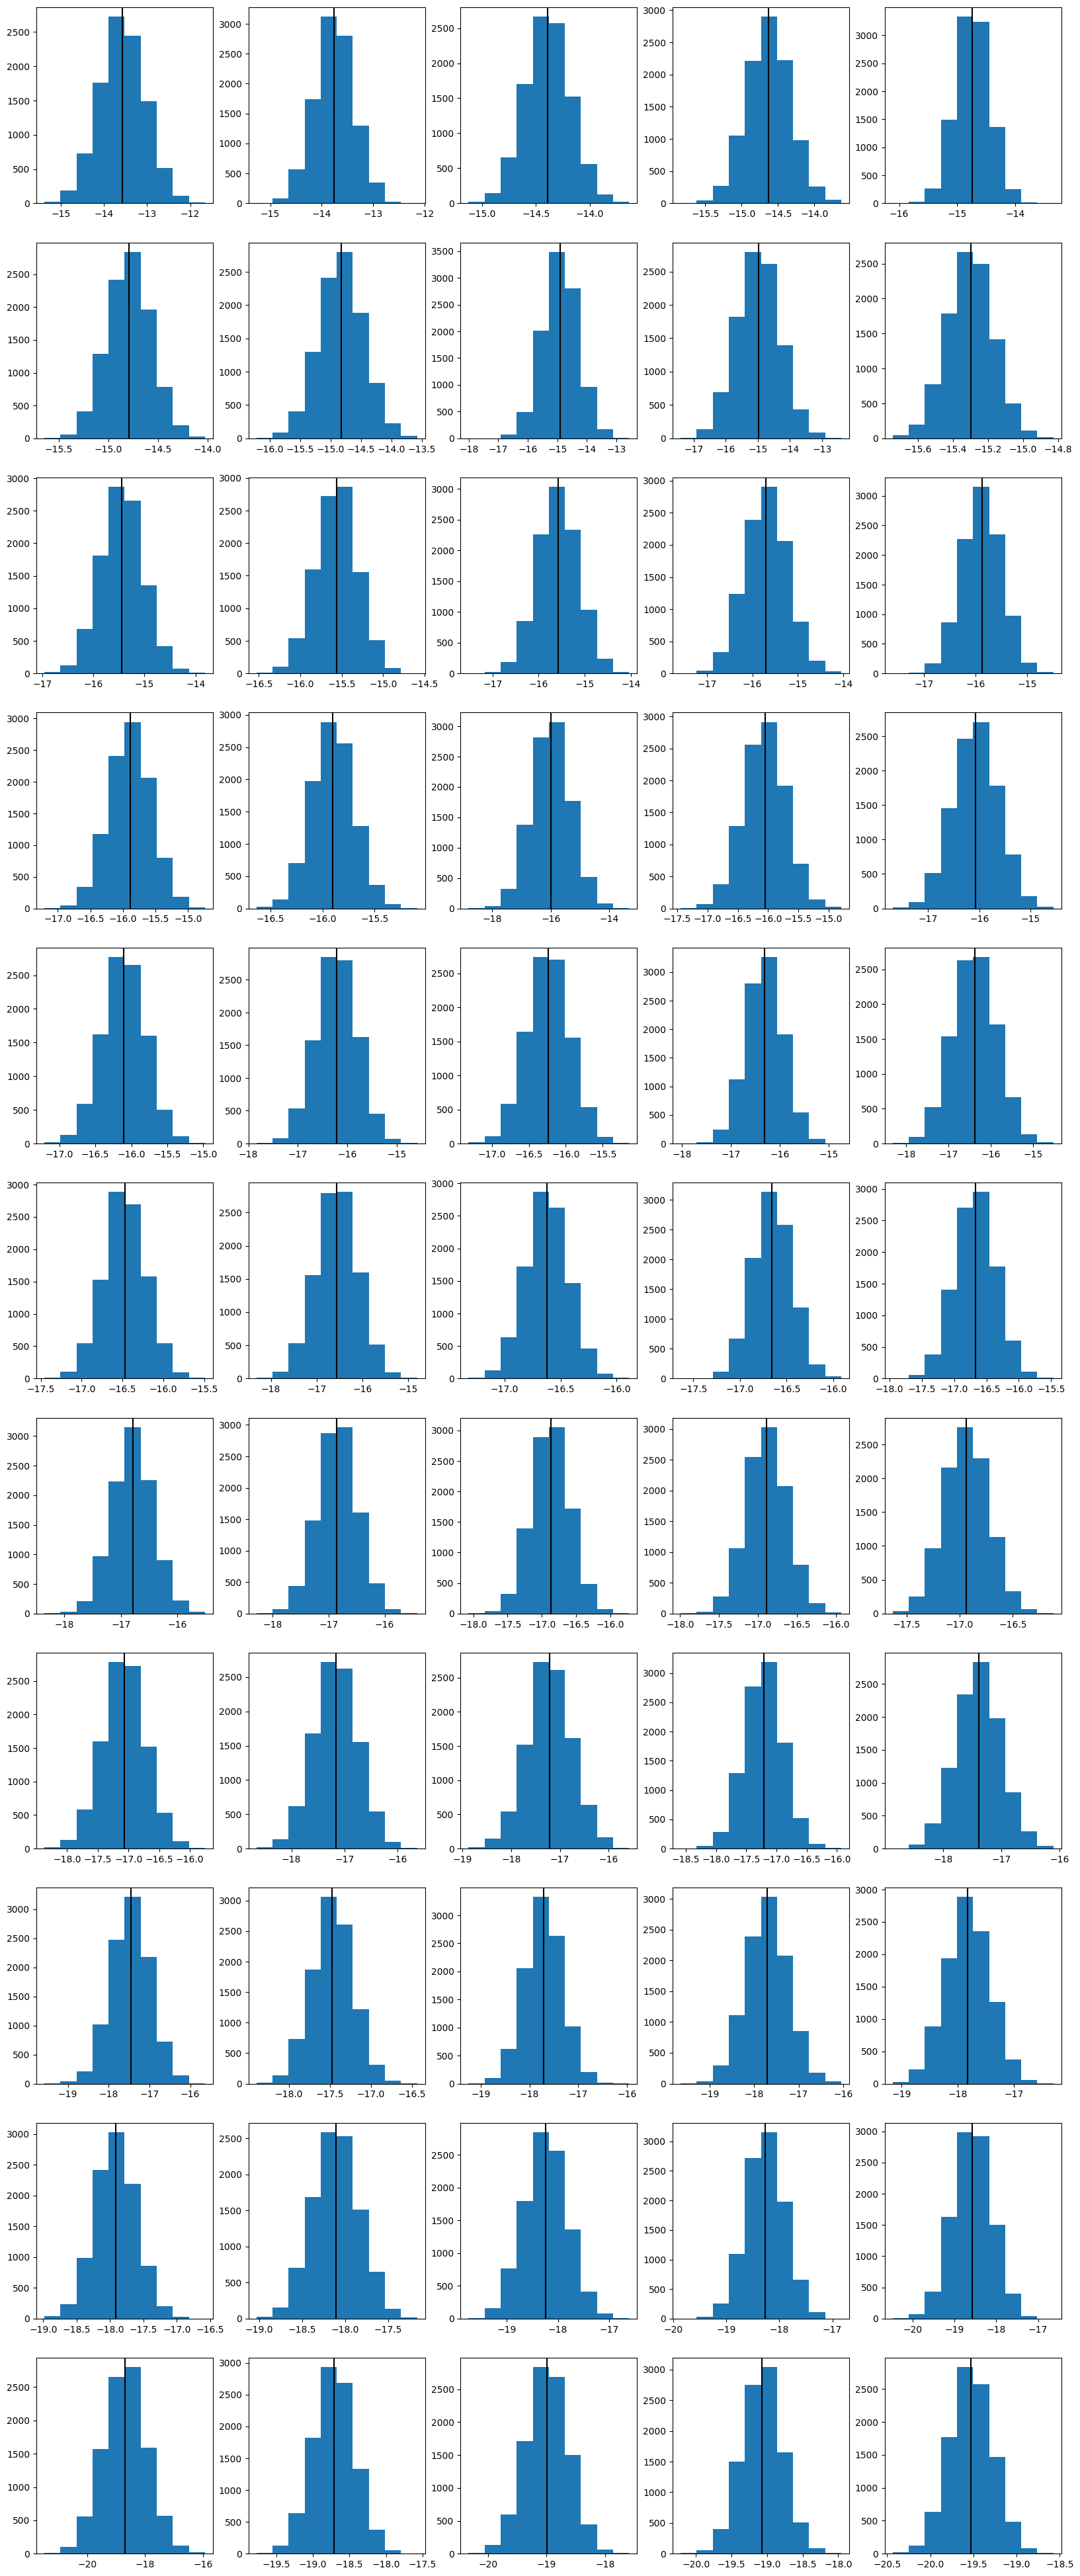

In [12]:
exp.plot_samples()

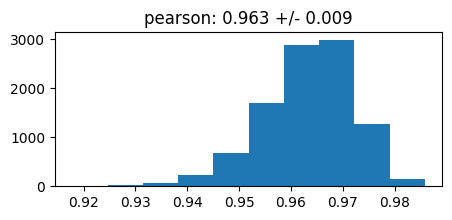

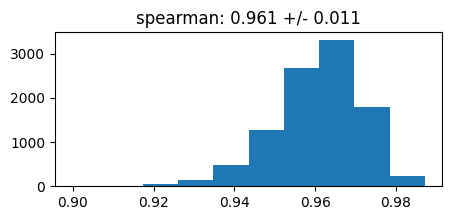

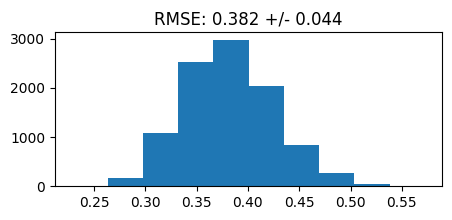

In [13]:
exp.plot_res()